In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [33]:
import torch.nn as nn
import torch.nn.functional as F

mseLoss = torch.nn.MSELoss()

rmse = []

class MLP(nn.Module):
    def __init__(self, X, dimA=100, dimB=20, dp=0.5):
        super(MLP, self).__init__()
        self.A = nn.Linear(X.shape[-1],dimA).float().cuda()
        self.B = nn.Linear(dimA,dimB).float().cuda()
        self.dB = nn.Linear(dimB,dimA).float().cuda()
        self.dA = nn.Linear(dimA,X.shape[-1]).float().cuda()
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, X):
        y = F.relu(self.A(X).squeeze())
#         y = F.relu(self.B(y).squeeze())
#         y = F.relu(self.dB(y).squeeze())
        y = self.dA(y).squeeze()
        return y
    
def validateRecon(model, X, testIdcs):
    model.eval()
    loss = None
    with torch.no_grad():
        recon = model(X)
        loss = mseLoss(recon[testIdcs], X[testIdcs]).cpu().numpy()**0.5
    model.train()
    return loss, recon

nEpochs = 1000
pPeriod = 100

for grp in range(1):
    trainIdcs = groups[grp][0][0:496]
    trainValidIdcs = groups[grp][0]
    validIdcs = np.arange(496,len(trainValidIdcs))
    testIdcs = groups[grp][1]

    X0 = nback_p_t
    X1 = emoid_p_t

    X = torch.stack([X0, X1], dim=1)
    Xt = X[trainIdcs]
    Xtv = X[trainValidIdcs]

    mlp = MLP(X, dimA=200, dimB=20, dp=0.5)
    optim = torch.optim.Adam(mlp.parameters(), lr=5e-4, weight_decay=5e-4)

    validLoss = []

    for epoch in range(nEpochs):
        optim.zero_grad()
        rec = mlp(Xt[:,0])
        loss = mseLoss(rec, Xt[:,0])
        loss.backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'epoch {epoch} loss={loss}')
            lss, _ = validateRecon(mlp, Xtv[:,0], validIdcs)
            if len(validLoss) == 0 or lss < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lss}')
                torch.save(mlp.state_dict(), f'../../Work/LatentSim/ae.pyt')
                validLoss.append(float(lss))

    mlp.load_state_dict(torch.load(f'../../Work/LatentSim/ae.pyt'))
    loss, recon = validateRecon(mlp, X[:,0], testIdcs)
        
    rmse.append(float(loss))

    print(f'FINISHED {rmse}')

epoch 0 loss=0.11479219049215317
New best validation epoch 0 loss=0.5140147805213928
epoch 100 loss=0.09806815534830093
New best validation epoch 100 loss=0.30681517720222473
epoch 200 loss=0.01742398366332054
New best validation epoch 200 loss=0.13292887806892395
epoch 300 loss=0.01614348031580448
New best validation epoch 300 loss=0.1288529932498932
epoch 400 loss=0.01586310751736164
New best validation epoch 400 loss=0.12806519865989685
epoch 500 loss=0.015793656930327415
New best validation epoch 500 loss=0.127821683883667
epoch 600 loss=0.01576922833919525
New best validation epoch 600 loss=0.12779489159584045
epoch 700 loss=0.015778379514813423
epoch 800 loss=0.01577025279402733
New best validation epoch 800 loss=0.127785325050354
epoch 900 loss=0.015781596302986145
epoch 999 loss=0.01576044037938118
New best validation epoch 999 loss=0.12772783637046814
FINISHED [0.12738308310508728]


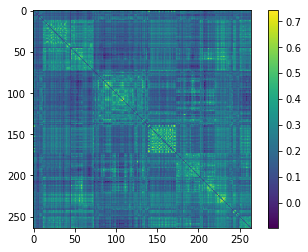

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def toImage(x, a, b, idcs):
    img = np.zeros((264,264))
    img[a[idcs],b[idcs]] = x[idcs]
    img = img + img.T
    return img

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

img = toImage(recon[1].detach().cpu().numpy(), a, b, idcs)
plt.imshow(img)
plt.colorbar()
plt.show()

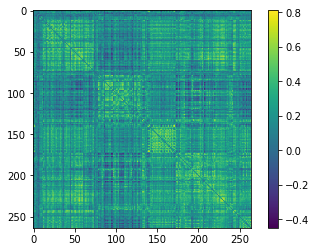

In [35]:
plt.imshow(toImage(X[1,0].detach().cpu().numpy(), a, b, idcs))
plt.colorbar()
plt.show()

In [30]:
torch.sum(recon < 0)

tensor(96817, device='cuda:0')